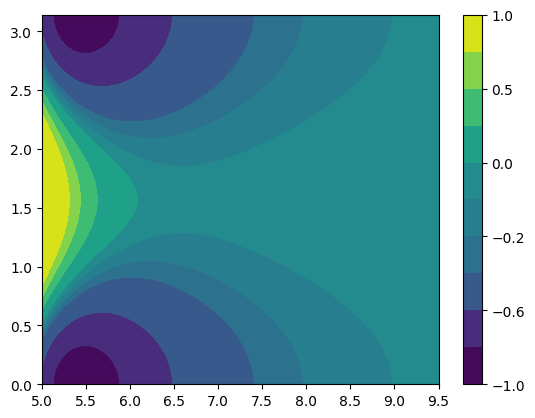

In [1]:
import numpy as np
import matplotlib.pyplot as plt

ANGS = 1.88973
DEB = 0.39343
EV = 0.03675

class Potential:
    def __init__(self, c12: float = 2.5e7, alpha: float = 6 * 27.8 * ANGS ** 3, mu: float = 2.38 * DEB) -> None:
        self.c12 = c12
        self.alpha = alpha
        self.mu = mu

    def value(self, r, theta):
        return self.c12 / r**12 - self.alpha * self.mu**2 / (2 * r**6) * (1 + 3 * np.cos(theta)**2)
    
r_points = np.linspace(5, 9.5, 100)
theta_points = np.linspace(0, np.pi, 100)

r_mesh, theta_mesh = np.meshgrid(r_points, theta_points)
potential = Potential().value(r_mesh, theta_mesh)
potential_ev = np.clip(potential / EV, -1, 1)

fig, ax = plt.subplots()
CS = ax.contourf(r_points, theta_points, potential_ev, levels=[-1, -0.9, -0.6, -0.3, -0.2, -0.1, 0, 0.25, 0.5, 0.75, 1])
fig.colorbar(CS)

In [2]:
import split_op as split
import numpy as np
from scipy.special import roots_legendre, lpmv
from tqdm import tqdm

from potential import load_potential
import os

data_path = "data/"
if not os.path.exists(data_path):
    os.makedirs(data_path)

KELVIN = 3.1668105e-6
U = 1822.88839
GHZ = 1.51983e-7

def centrifugal(r_points, j_tot: int, omega: int, mass_u: float):
    return (j_tot * (j_tot + 1) - 2 * omega * omega) / (2 * mass_u * U * np.power(r_points, 2))

In [3]:
from typing import Callable

def prepare(j_init: int, 
    omega_init: int, 
    j_tot: int, 
    time_step: float = 20, 
    steps_no: float = 4000, 
    r_start: float = 40 / 1024, 
    r_end: float = 40, 
    r_no: int = 1024, 
    polar_no: int = 200, 
    mass_u: float = 16.923076923,
    energy_kelvin: float = 5802.45, 
    rot_const = 5.614 * GHZ,
    wave_r0: float = 20,
    wave_r_sigma: float = 1,
    animation: bool = False,
    frames: int = 60,
    wave_prefix: str = "hyq",
    transform_potential: Callable[[float, float], float] = None,
) -> split.Propagation:
    """
    Prepares the split operator propagation of the Ne OCS problem.

    :j_init: initial angular momentum of the OCS molecule
    :omega_init: initial body fixed projection of the OCS angular momentum equal to projection of the total angular momentum
    :j_tot: total angular momentum of the system
    :time_step: time step in the Hartree units of the propagation step
    :steps_no: number of steps in the propagation
    :r_start: starting value of the radial grid
    :r_end: ending value of the radial grid
    :r_no: number of points of the radial grid
    :polar_no: number of points of the angular grid
    :mass_u: reduced mass of the Ne OCS in u units
    :energy_kelvin: energy of the collision in Kelvin units
    :rot_const: rotational constant of the OCS molecule in Hartree units
    :wave_r0: initial radial position of the wave funciton
    :wave_r_sigma: initial radial width of the wave funciton
    :animation: whether to save animations of the wave function
    :frames: number of frames of the animation
    :wave_prefix: prefix of the wave animation filename to be saved
    """

    assert j_tot >= omega_init
    assert j_init >= omega_init

    ############################ grids, wave function creation ################################
    
    time_grid = split.TimeGrid(time_step, steps_no)
    r_grid = split.Grid.linear_continuos("r", r_start, r_end, r_no, 0)
    
    polar_points, weights = roots_legendre(polar_no)
    polar_points = np.flip(np.arccos(polar_points))
    weights = np.flip(weights)
    
    polar_grid = split.Grid.custom("theta", polar_points, weights, 1)

    r_points = np.array(r_grid.points())
    momentum = np.sqrt(2 * mass_u * U * energy_kelvin * KELVIN)

    wave_r_init = np.array([split.gaussian_distribution(r_points[i], wave_r0, wave_r_sigma, momentum) for i in range(r_no)])
    wave_polar_init = lpmv(omega_init, j_init, np.cos(polar_points))

    wave_init = np.outer(wave_r_init, wave_polar_init)
    wave_function = split.WaveFunction(wave_init.flatten(), [r_grid, polar_grid])

    ############################ operation creation ################################

    r_mesh, polar_mesh = np.meshgrid(r_points, polar_points, indexing="ij")

    potential = Potential().value(r_mesh, polar_mesh)
    if transform_potential is not None:
        potential = np.multiply(potential, transform_potential(r_mesh, polar_mesh))

    centrifugal_potential = centrifugal(r_points, j_tot, omega_init, mass_u)
    centrifugal_potential = np.broadcast_to(np.expand_dims(centrifugal_potential, 1), (r_no, polar_no))

    potential = potential + centrifugal_potential
    potential_prop = split.complex_n_dim_into_propagator(potential.shape, potential.flatten(), time_grid)

    leak_control = split.LeakControl(split.LossChecker("leak control"))
    dumping_border = split.BorderDumping(5., 1., r_grid)

    angular_transformation = None
    angular_prop = None

    if omega_init == 0:
        angular_transformation = split.legendre_transformation(polar_grid)

        shape, angular_kinetic_op = split.rotational_hamiltonian(r_grid, polar_grid, mass_u, rot_const)
        angular_prop = split.n_dim_into_propagator(shape, angular_kinetic_op, time_grid)
    else:
        l_grid = split.Grid.linear_countable("angular_momentum",
                                             np.abs(omega_init),
                                             polar_no - 1 + np.abs(omega_init),
                                             polar_no,
                                             1)
        transformation_matrix = np.zeros((polar_no, polar_no), dtype=complex)
        l_points = np.array(l_grid.points())

        assert omega_init >= 0
        for i in range(polar_no):
            normalization = 1
            for k in range(-omega_init, omega_init):
                normalization *= l_points[i] + 1 + k

            transformation_matrix[i, :] = np.sqrt(weights * (l_points[i] + 0.5) / normalization) \
                * lpmv(omega_init, l_points[i], np.cos(polar_points))
            
        q, r = np.linalg.qr(transformation_matrix.transpose())
        transformation_matrix = q.transpose()
        inverse_transformation = (transformation_matrix / np.sqrt(weights)).transpose()
        transformation_matrix *= np.sqrt(weights)

        angular_transformation = split.MatrixTransformation(polar_grid, l_grid)
        angular_transformation.set_matrix(transformation_matrix.flatten(), inverse_transformation.flatten())

        rot_hamiltonian = (1 / (2 * mass_u * U * r_mesh ** 2) + rot_const) * l_points * (l_points + 1)

        angular_prop = split.n_dim_into_propagator(rot_hamiltonian.shape, rot_hamiltonian.flatten(), time_grid)

    fft_transformation = split.FFTTransformation(r_grid, "r momentum")

    kinetic_op = split.kinetic_hamiltonian(r_grid, mass_u, energy_kelvin)
    kinetic_prop = split.one_dim_into_propagator(kinetic_op, r_grid, time_grid, step = "full")

    ################################ populating operation stack ####################################

    operation_stack = split.OperationStack()
    potential_prop.add_operation(operation_stack)

    if animation:
        wave_saver = split.WaveFunctionSaver(data_path, f"{wave_prefix}_wave_animation", time_grid, r_grid, polar_grid, frames)
        wave_saver.add_operation(operation_stack)

        polar_saver = split.StateSaver(data_path, f"{wave_prefix}_polar_animation", time_grid, polar_grid, 2 * frames)
        polar_saver.add_operation(operation_stack)

    dumping_border.add_operation(operation_stack)
    leak_control.add_operation(operation_stack)

    angular_transformation.add_operation(operation_stack, True)

    if animation:
        angular_grid = angular_transformation.transformed_grid()
        wave_legendre_saver = split.StateSaver(data_path, f"{wave_prefix}_angular_animation", time_grid, angular_grid, frames)
        wave_legendre_saver.add_operation(operation_stack)

    angular_prop.add_operation(operation_stack)

    fft_transformation.add_operation(operation_stack, True)
    kinetic_prop.add_operation(operation_stack)

    ################################ propagation creation ####################################

    propagation = split.Propagation()
    propagation.set_wave_function(wave_function)
    propagation.set_time_grid(time_grid)
    propagation.set_operation_stack(operation_stack)

    return propagation

In [4]:
print("j init: 0, omega init: 0, j_tot: 0")
propagation = prepare(0, 0, 0, animation=True, wave_prefix="hyq_0.5")

propagation.propagate()
propagation.get_losses()
propagation.save_savers()

print("j init: 0, omega init: 0, j_tot: 0")
propagation = prepare(0, 0, 0, animation=True, energy_kelvin=1160.49, steps_no=8000, wave_prefix="hyq_0.1")

propagation.propagate()
propagation.get_losses()
propagation.save_savers()

print("j init: 0, omega init: 0, j_tot: 0")
propagation = prepare(0, 0, 0, animation=True, energy_kelvin=580.245, steps_no=12000, wave_prefix="hyq_0.05")

propagation.propagate()
propagation.get_losses()
propagation.save_savers()

j init: 0, omega init: 0, j_tot: 0
j init: 0, omega init: 0, j_tot: 0
j init: 0, omega init: 0, j_tot: 0
